In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('citibike_data/citibike_2018.csv')

### Confusion Matrix function: 

In [14]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    plt.figure(figsize=(20,12))
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')
    plt.xticks(rotation=90)
    plt.colorbar()

In [16]:
df_small = df.sample(25000)

Split variables from targets: 

In [3]:
labels = df.stop_nhbr

Use LabelEncoder to convert target labels into a categories: 

In [4]:
# labels = le.fit_transform(labels.astype(str))
labels_removed_df = df.drop('stop_nhbr', axis=1)

Scale data: 

In [5]:
# scaler = StandardScaler()
# scaled_df = scaler.fit_transform(labels_removed_df)

Split data into training and testing sets.  Maintain at least some of each target class in both sets with the 'stratify' argument. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(labels_removed_df, labels)

Fit xgboost model: 

In [7]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=6, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                             bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                             warm_start=False, class_weight=None)

In [8]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
training_preds = clf.predict(X_train)

In [10]:
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 7.708%
Validation accuracy: 7.657%


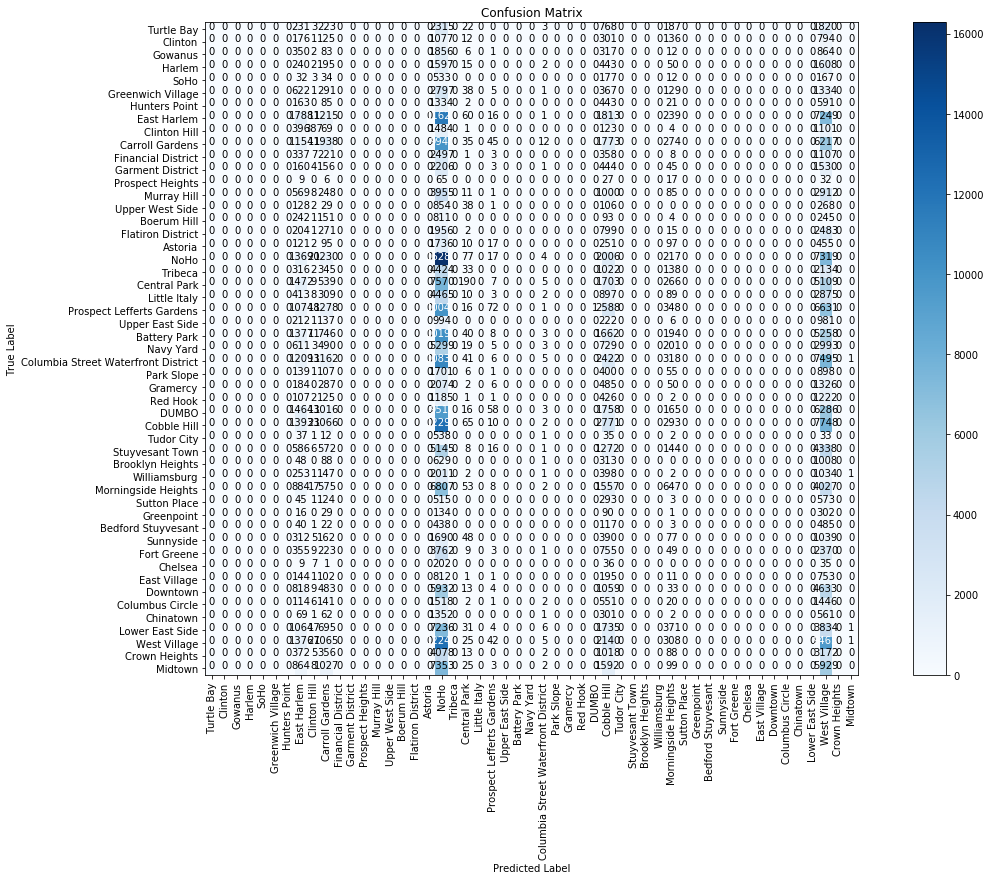

In [15]:
show_cf(y_test, val_preds)

In [ ]:
param_grid = {
    "criterion" : ['gini', 'entropy']
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5],
    'n_estimators': [300, 400, 500],
}

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
eval_metric = ["auc", 'error']
eval_set = [(X_train, y_train), (X_test, y_test)]
grid_clf.fit(X_train, y_train, eval_set= eval_set, early_stopping_rounds=5)
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
clf.feature_importances_

In [ ]:
cf = confusion_matrix(y_test, val_preds)
cf

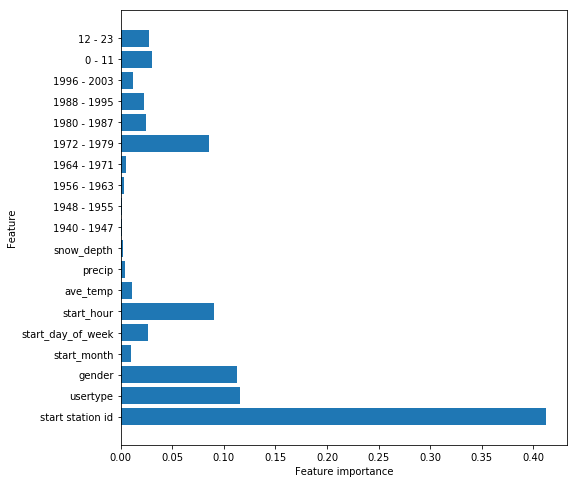

In [17]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(clf)